This notebook needs to have the hovernet previously done on the WSIs and just use the results to analysis them.

In [1]:
import warnings
import scipy.io
import json
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
warnings.filterwarnings("ignore")
path_folder = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/'
filenames_5x = os.listdir(path_folder)
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
sys.path.append(main_path)

from models.clustering.data_processing import *
figure_path = '{}/workflow/figures/hovernet/'.format(main_path)
if not os.path.exists(figure_path): os.makedirs(figure_path, exist_ok=True)



In [2]:
groupby = 'leiden_2.0'
meta_folder = '750K'
dataset = 'Meso'
fold_number = 4

h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

Matching the tiles between 20X and 5X

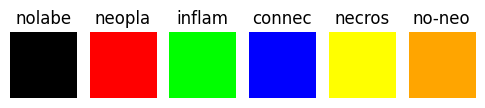

In [18]:
# from: https://github.com/vqdang/hover_net/blob/master/type_info.json
color_dict = {
    "0" : ["nolabe", [0  ,   0,   0]], 
    "1" : ["neopla", [255,   0,   0]], 
    "2" : ["inflam", [0  , 255,   0]], 
    "3" : ["connec", [0  ,   0, 255]], 
    "4" : ["necros", [255, 255,   0]], 
    "5" : ["no-neo", [255, 165,   0]] 
}

fig, ax = plt.subplots(1,6, figsize=(6,1))
for i in range(0,6):
    color = color_dict[str(i)][1]
    label = color_dict[str(i)][0]
    ax[i].imshow(np.array(color).reshape(1,1,3))
    ax[i].set_title(label)
    ax[i].axis('off')
plt.show()

In [4]:
# # show the 5x version of the image
# path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_277_6_files/5.0/{}_{}.jpeg'.format(i_5x, j_5x)
# image = cv2.imread(path)
# plt.imshow(image)
# plt.show()

#### Color Guidence

/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/56_24.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/56_25.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/56_26.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/56_27.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/57_24.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/57_27.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/58_25.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/58_26.json
/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/json/58_27.json


{'MESO_277_6_files': {'14_6.jpeg': {'neopla': 197,
   'connec': 124,
   'inflam': 12,
   'nolabe': 4,
   'no-neo': 1,
   'necros': 2}}}

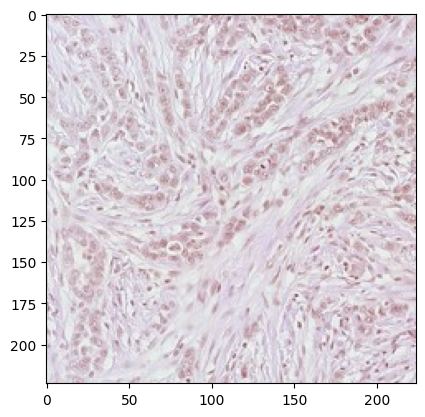

In [54]:
path_folder = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/'
filenames_5x = os.listdir(path_folder)

nuc_types = dict()
for filename in filenames_5x[:1]:
    nuc_types[filename] = dict()
    tiles = os.listdir(path_folder + filename + '/5.0/')
    for tile in tiles[:1]:
        tile = '14_6.jpeg'
        # show the 5x version of the image
        path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/{}/5.0/{}'.format(filename, tile)
        image = cv2.imread(path)
        plt.imshow(image)
        i_5x, j_5x = tile.split('.jpeg')[0].split('_')
        i_5x, j_5x = int(i_5x), int(j_5x)
        start_i, start_j = i_5x*4, j_5x*4
        # start_i_5x, start_j_5x = tile.split('.jpeg')[0].split('_')
        # start_i, start_j = int(start_i_5x)*4, int(start_j_5x)*4
        nuc_types[filename][tile] = dict()
        for i in range(start_i, start_i+4):
            for j in range(start_j, start_j+4):
                try:
                    path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/{}/20.0/json/{}_{}.json'.format(filename,i,j)
                    json_file = open(path)
                    data = json.load(json_file)
                    for i_nuc in data['nuc']:
                        type_index = str(data['nuc'][i_nuc]['type'])
                        nuc_type_key = color_dict[type_index][0]
                        nuc_types[filename][tile][nuc_type_key] = nuc_types[filename][tile].get(nuc_type_key, 0) + 1
                except:
                    print(path)
                    pass

nuc_types

In [8]:
ls -lh '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/'

total 168M
drwxrwxr-x 2 fshahi domain users  332 Aug  8 10:19 adatas/
drwxr-xr-x 3 fshahi domain users    6 Aug 14 17:28 alpha_5.0/
drwxr-xr-x 2 fshahi domain users    5 Jul 26 14:11 cph_0.05_0.1/
drwxr-xr-x 5 fshahi domain users    4 May 15 11:03 leiden_1p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:13 leiden_1p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 23 12:09 leiden_1p5_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:32 leiden_1p5_fold4/
drwxr-xr-x 5 fshahi domain users    4 May  4 11:47 leiden_2p0_fold0/
drwxr-xr-x 6 fshahi domain users    6 Jul 14 13:42 leiden_2p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 23 12:17 leiden_2p5_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:37 leiden_2p5_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 15 10:06 leiden_3p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:41 leiden_3p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 16 10:19 leiden_4p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23

[ WARN:0@2313.694] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/overlay/56_24.png'): can't open/read file: check file path/integrity
[ WARN:0@2313.695] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_277_6_files/20.0/56_24.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@2313.695] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/overlay/56_25.png'): can't open/read file: check file path/integrity
[ WARN:0@2313.695] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_277_6_files/20.0/56_25.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@231

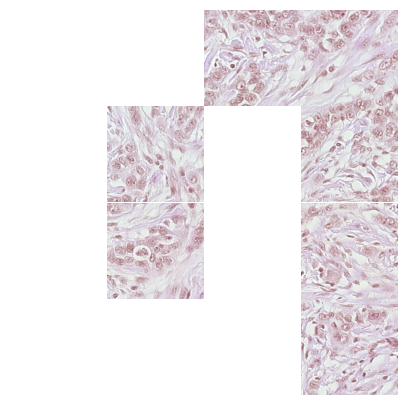

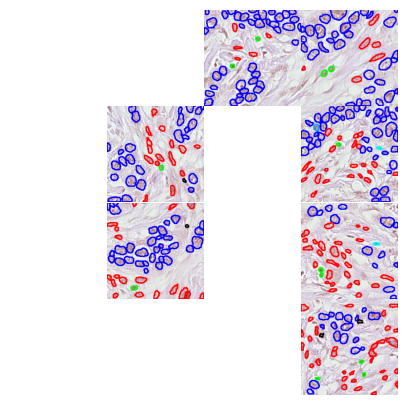

In [55]:
fig1, ax1 = plt.subplots(4,4, figsize=(5,5))
fig2, ax2 = plt.subplots(4,4, figsize=(5,5))

#  make the space between the plots to zero
fig1.subplots_adjust(hspace=0, wspace=0)
fig2.subplots_adjust(hspace=0, wspace=0)

# off the grids
for ax in ax1.flat:
    ax.axis('off')
for ax in ax2.flat:
    ax.axis('off')

i_5x, j_5x = 14,6
start_i, start_j = i_5x*4, j_5x*4


for i in range(start_i, start_i+4):
    for j in range(start_j, start_j+4):
        try:
            folder, format_ = 'overlay', 'png'
            path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/overlay/{}_{}.png'.format(i,j)
            overlay = cv2.imread(path)

            # load the original image
            path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_277_6_files/20.0/{}_{}.jpeg'.format(i, j)
            image = cv2.imread(path)

            i_plot = i-start_i
            j_plot = j-start_j

            ax1[j_plot, i_plot].imshow(image)
            ax2[j_plot, i_plot].imshow(overlay)
        except:
            pass

plt.show()
# fig1.savefig('{}/original_tile.png'.format(figure_path))
# fig2.savefig('{}/overlay_tile.png'.format(figure_path))


In [27]:
ls -lh '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/'

total 38M
drwxrwxr-x 2 fshahi domain users  332 Aug  8 10:19 adatas/
drwxr-xr-x 3 fshahi domain users    6 Aug 14 17:28 alpha_5.0/
drwxr-xr-x 2 fshahi domain users    5 Jul 26 14:11 cph_0.05_0.1/
drwxr-xr-x 5 fshahi domain users    4 May 15 11:03 leiden_1p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:13 leiden_1p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 23 12:09 leiden_1p5_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:32 leiden_1p5_fold4/
drwxr-xr-x 5 fshahi domain users    4 May  4 11:47 leiden_2p0_fold0/
drwxr-xr-x 6 fshahi domain users    6 Jul 14 13:42 leiden_2p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 23 12:17 leiden_2p5_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:37 leiden_2p5_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 15 10:06 leiden_3p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:41 leiden_3p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 16 10:19 leiden_4p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 

In [30]:
ls -lh '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/'

total 18G
-rw-r--r-- 1 fshahi domain users   23K Apr 29 10:27 '20x_hovernet_files (copy).txt'
-rw-r--r-- 1 fshahi domain users    50 Jul 15 13:25  20x_hovernet_files_temp.txt
-rw-r--r-- 1 fshahi domain users   22K Jul 16 11:09  20x_hovernet_files.txt
-rw-r--r-- 1 fshahi domain users 1022M Jul 25 19:48  debug.log
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_106_1_files/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_107_1_files/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_107_2_files/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_107_5_files/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_107_6_files/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_108_13_files/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11 'MESO_108_14(1)_files'/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11 'MESO_108_14(2)_files'/
drwxr-xr-x 4 fshahi domain users     2 Apr 24 14:11  MESO_108_14_files/
drwxr-xr-x 4 fshahi domain users   

In [13]:
nuc_types_df = pd.read_csv('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/nuc_types_full_v2cleaned.csv', chunksize=200000)
nuc_types_df.columns = ['slides', 'tiles', 'necrosis', 'neoplastic', 'inflammation', 'connective', 'no-neo', 'nolabe']
for chunk in nuc_types_df:
    # chunk.columns = ['slides', 'tiles', 'necrosis', 'neoplastic', 'inflammation', 'connective', 'no-neo', 'nolabe']
    display(chunk)
    # display(chunk[chunk['tiles']=='14_6.jpeg'])
    # drop the repeated rows
    chunk = chunk.drop_duplicates()
    display(chunk)
    # display(chunk[chunk['tiles']=='14_6.jpeg'])

    break

,slides,tiles,nolabe,neopla,inflam,connec,necros,no-neo
0,MESO_277_6_files,36_27.jpeg,8,103,28,328,3,50
1,MESO_277_6_files,18_15.jpeg,5,260,10,227,4,7
2,MESO_277_6_files,14_6.jpeg,4,197,12,124,2,1
3,MESO_277_6_files,16_37.jpeg,14,724,9,107,5,23
4,MESO_277_6_files,40_21.jpeg,1,46,11,142,28,15
...,...,...,...,...,...,...,...,...
199995,MESO_247_4_files,26_27.jpeg,19,313,39,207,49,289
199996,MESO_247_4_files,32_27.jpeg,32,360,153,91,114,608
199997,MESO_247_4_files,19_18.jpeg,6,102,3,111,31,35
199998,MESO_247_4_files,29_19.jpeg,5,184,39,107,75,150


,slides,tiles,nolabe,neopla,inflam,connec,necros,no-neo
0,MESO_277_6_files,36_27.jpeg,8,103,28,328,3,50
1,MESO_277_6_files,18_15.jpeg,5,260,10,227,4,7
2,MESO_277_6_files,14_6.jpeg,4,197,12,124,2,1
3,MESO_277_6_files,16_37.jpeg,14,724,9,107,5,23
4,MESO_277_6_files,40_21.jpeg,1,46,11,142,28,15
...,...,...,...,...,...,...,...,...
199995,MESO_247_4_files,26_27.jpeg,19,313,39,207,49,289
199996,MESO_247_4_files,32_27.jpeg,32,360,153,91,114,608
199997,MESO_247_4_files,19_18.jpeg,6,102,3,111,31,35
199998,MESO_247_4_files,29_19.jpeg,5,184,39,107,75,150


In [3]:
# fetch clusters
nuc_types_df = pd.read_csv('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/nuc_types_full_v2cleaned.csv')
csv = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/Meso_he_complete_filtered_metadata_leiden_2p0__fold4.csv'
clusters = pd.read_csv(csv)
clusters = clusters[['tiles', 'leiden_2.0', 'slides']]
clusters['slides'] = clusters['slides'].apply(lambda x: x+'_files') # add _files to the slides to match dictionary
clusters = clusters[clusters['slides'].isin(filenames_5x)] # filter out the slides that are in the dictionary
print('Number of clusters:',clusters['leiden_2.0'].value_counts().shape[0])
print('Number of slides:',clusters['slides'].value_counts().shape[0])

# merge the dataframes
df = nuc_types_df.merge(clusters, on=['slides', 'tiles'], how='inner')
print('Number of clusters:',df['leiden_2.0'].value_counts().shape[0])
print('Number of slides:',df['slides'].value_counts().shape[0])
df

Number of clusters: 47
Number of slides: 895
Number of clusters: 47
Number of slides: 892


,slides,tiles,nolabe,neopla,inflam,connec,necros,no-neo,leiden_2.0
0,MESO_277_6_files,36_27.jpeg,8,103,28,328,3,50,13
1,MESO_277_6_files,18_15.jpeg,5,260,10,227,4,7,39
2,MESO_277_6_files,14_6.jpeg,4,197,12,124,2,1,39
3,MESO_277_6_files,16_37.jpeg,14,724,9,107,5,23,37
4,MESO_277_6_files,40_21.jpeg,1,46,11,142,28,15,42
...,...,...,...,...,...,...,...,...,...
799229,MESO_111_26_files,35_17.jpeg,0,9,52,104,6,14,38
799230,MESO_111_26_files,42_28.jpeg,2,151,2,15,2,125,25
799231,MESO_111_26_files,26_12.jpeg,0,3,9,38,10,42,4
799232,MESO_111_26_files,19_17.jpeg,2,10,5,45,49,29,10


Group By Slides DataFrame by Clusters

In [22]:
# plotting_dfs.to_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/nuc_types_hovernet_clusters.csv', index=False)
# df.to_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/nuc_types_hovernet.csv', index=False)

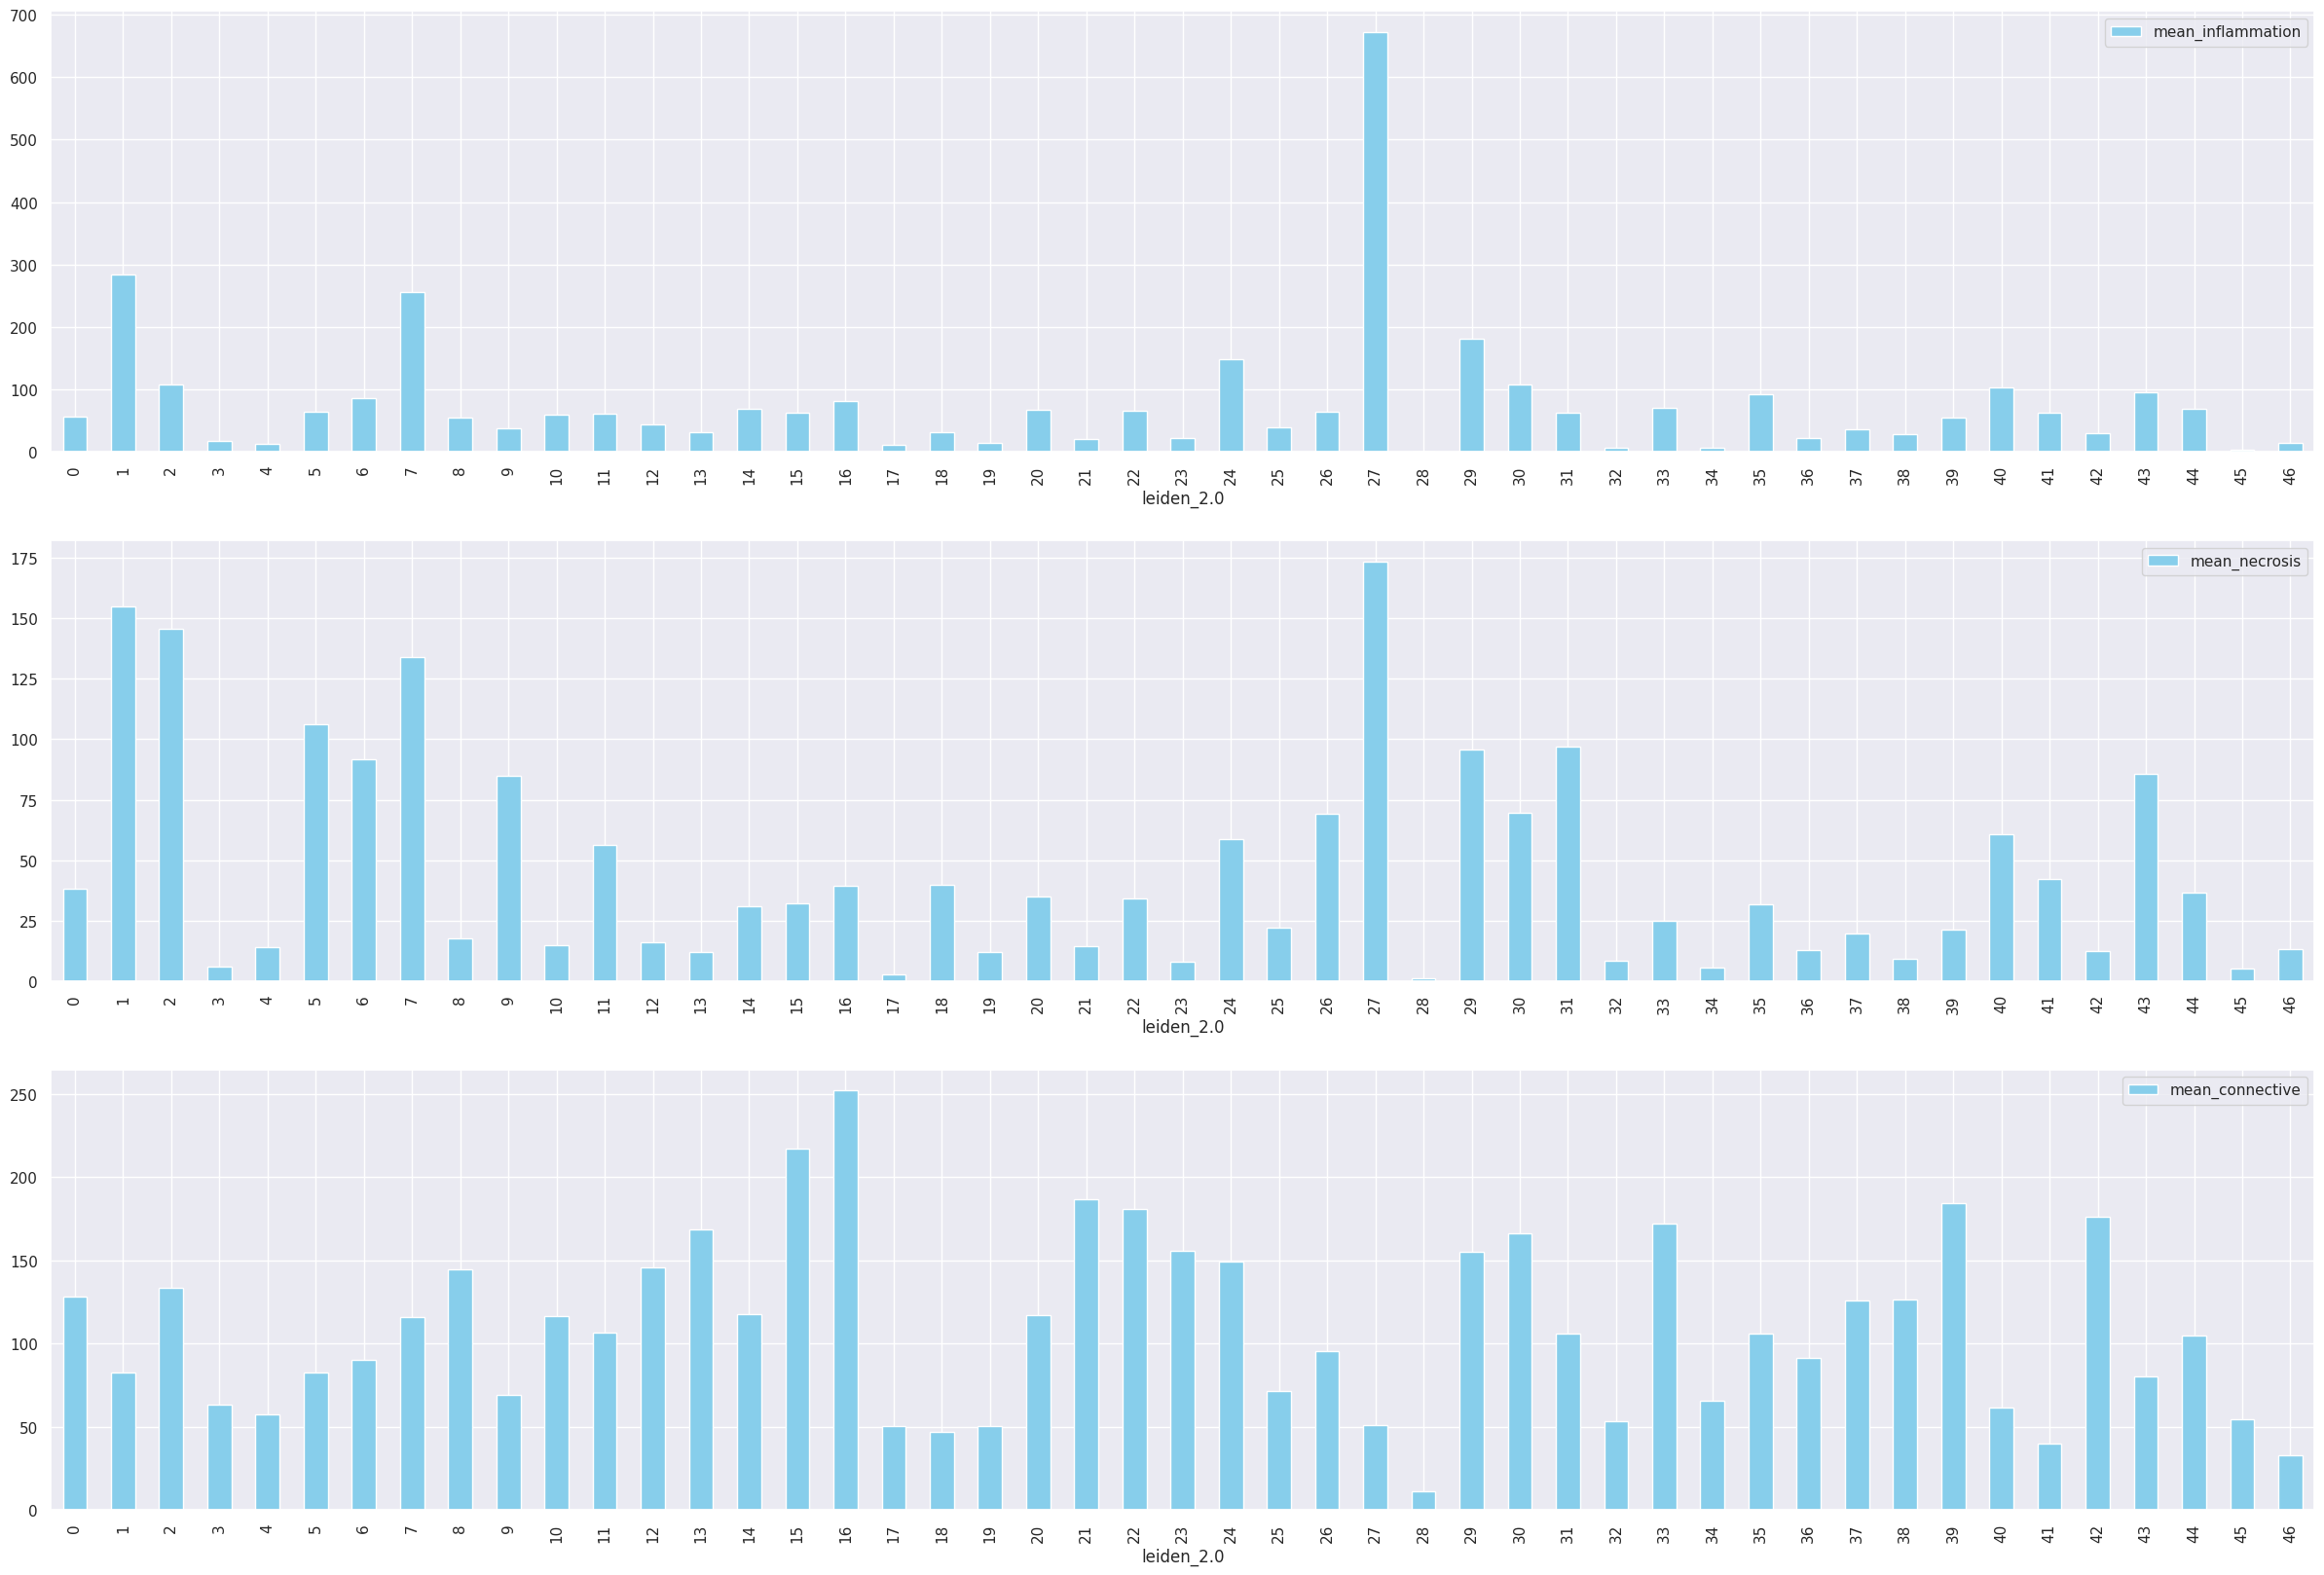

In [5]:
plotting_dfs = df.drop('slides', axis=1)
sns.set(style="darkgrid")
plotting_dfs = plotting_dfs.groupby('leiden_2.0')
tiles_per_cluster = [len(plotting_dfs.get_group(i)) for i in plotting_dfs.groups]
plotting_dfs = plotting_dfs.sum()
plotting_dfs['tiles'] = tiles_per_cluster
plotting_dfs['mean_inflammation'] = plotting_dfs['inflam']/plotting_dfs['tiles']
plotting_dfs['mean_necrosis'] = plotting_dfs['necros']/plotting_dfs['tiles']
plotting_dfs['mean_connective'] = plotting_dfs['connec']/plotting_dfs['tiles']
plotting_dfs = plotting_dfs.reset_index()
temp = plotting_dfs[['mean_inflammation', 'mean_necrosis', 'mean_connective', 'leiden_2.0']]

# plot each column of the dataframe
fig, ax = plt.subplots(3,1, figsize=(30,20))
ax = ax.flatten()
for i, col in enumerate(['mean_inflammation', 'mean_necrosis', 'mean_connective']):
    temp.plot(x='leiden_2.0', y=col, kind='bar', ax=ax[i], color='skyblue')

plt.savefig('{}/nuc_types_hovernet_clusters.png'.format(figure_path))

Get Pictures For Top Clusters (For the next figure legend)

In [16]:
top_5_inflammation = temp.sort_values(by='mean_inflammation', ascending=False).head(5)
top_5_necrosis = temp.sort_values(by='mean_necrosis', ascending=False).head(4)
top_5_connective = temp.sort_values(by='mean_connective', ascending=False).head(4)


im_list_dict = dict()
for class_ in ['mean_inflammation', 'mean_necrosis', 'mean_connective']:
    im_list = []
    if class_ == 'mean_inflammation': cluster_set = top_5_inflammation['leiden_2.0'].astype(str).tolist()
    elif class_ == 'mean_necrosis': cluster_set = top_5_necrosis['leiden_2.0'].astype(str).tolist()
    elif class_ == 'mean_connective': cluster_set = top_5_connective['leiden_2.0'].astype(str).tolist()
    for cluster_number in cluster_set:
        indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
        i_rand = np.random.randint(0, len(indexes))
        index_ = indexes[i_rand]
        set_ = sets[i_rand]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
        h5_image.close()
    im_list_dict[class_] = im_list

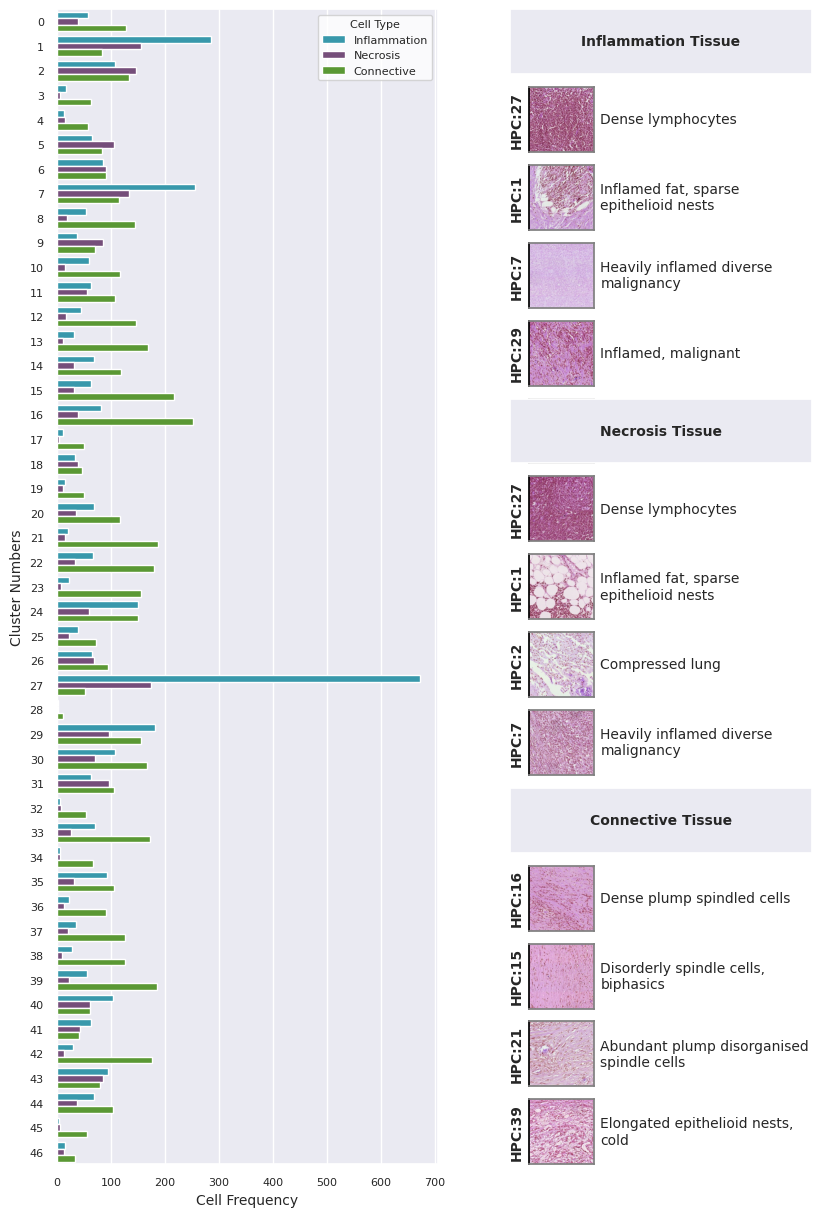

In [14]:
ncol, nrow = 10, 15
fig = plt.figure(figsize=(ncol, nrow))
gs = fig.add_gridspec(nrow, ncol)
j = 5
ax = fig.add_subplot(gs[0:15,0:j])
sns.set_theme(style="whitegrid")
test_data_melted = pd.melt(temp, id_vars='leiden_2.0',var_name="Cell Type", value_name="Cell Frequency")
test_data_melted["Cell Type"] = test_data_melted["Cell Type"].str.replace('mean_', '').str.capitalize()
colors = ["#25a5be", "#7b4682", "#56a923"]
ax = sns.barplot(y='leiden_2.0', x="Cell Frequency", hue="Cell Type",data=test_data_melted, palette=colors, orient='h', ax=ax)
ax.tick_params(labelsize=8)
ax.legend(title='Cell Type', title_fontsize='8', fontsize='8')
ax.set_xlabel("Cell Frequency",fontsize=10)
ax.set_ylabel("Cluster Numbers",fontsize=10)


import textwrap
sns.set_style("dark")
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

for class_ in ['mean_inflammation', 'mean_necrosis', 'mean_connective']:
    im_list = im_list_dict[class_]
    if class_ == 'mean_inflammation':
        title = 'Inflammation Tissue'
        i = 0
    elif class_ == 'mean_necrosis':
        title = 'Necrosis Tissue'
        i = 5
    elif class_ == 'mean_connective':
        title = 'Connective Tissue'
        i = 10

    ax = fig.add_subplot(gs[i,j+1:])
    ax.set(xticks=[], yticks=[])
    ax.text(.5, 0.5, textwrap.fill(title, 30), fontsize=10, ha='center', va='center', weight='bold')
    pos = ax.get_position()
    ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
    i += 1

    for (image, cluster_number) in im_list:

        ax = fig.add_subplot(gs[i, j:])
        if image is not None:
            ax.imshow(image)
        else:
            cluster_number = cluster_number.split('_')[0]
        ax.set(xticks=[], yticks=[])
        i += 1

        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=10))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])


        annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
        label_text = annotation_text
        ax.text(1.1, .5, label_text,
                    transform=ax.transAxes,
                    horizontalalignment="left", verticalalignment="center", size="small", )
# plt.show()
plt.savefig('{}/top_clusters_all.png'.format(figure_path))

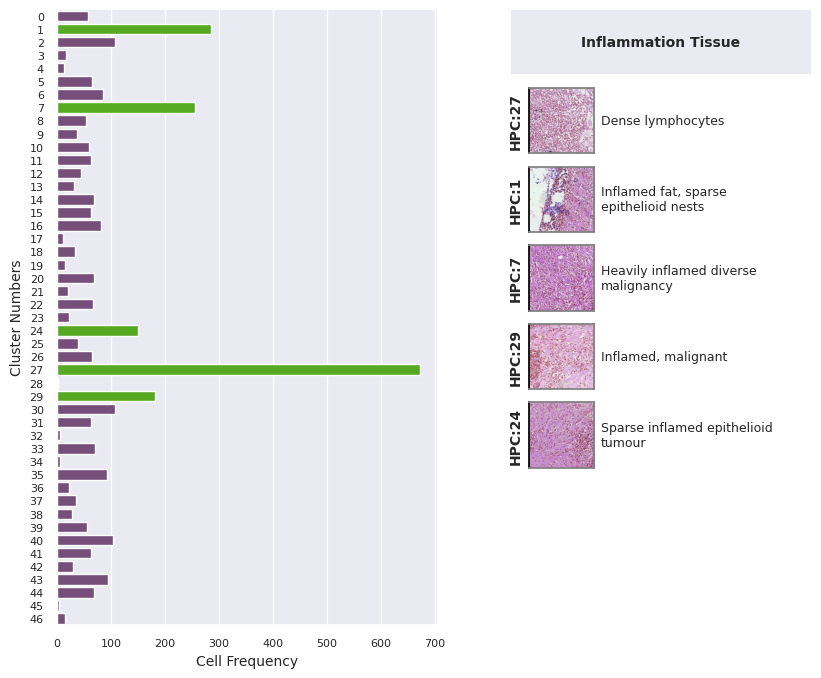

In [17]:
ncol, nrow = 10, 8
fig = plt.figure(figsize=(ncol, nrow))
gs = fig.add_gridspec(nrow, ncol)
j = 5
im_list = im_list_dict['mean_inflammation']
hpc_list = [int(im_list[i][1]) for i in range(0,len(im_list))]



ax = fig.add_subplot(gs[0:15,0:j])
sns.set_theme(style="darkgrid")
ax = sns.barplot(y='leiden_2.0', x="mean_inflammation",data=temp, orient='h', color='#7b4682', ax=ax)

# change the color of three specific clusters
for ind in hpc_list:
    ax.patches[ind].set_facecolor("#56a923")
ax.tick_params(labelsize=8)
ax.set_xlabel("Cell Frequency",fontsize=10)
ax.set_ylabel("Cluster Numbers",fontsize=10)


import textwrap
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
title = 'Inflammation Tissue'
i = 0
ax = fig.add_subplot(gs[i,j+1:])
ax.set(xticks=[], yticks=[])
ax.text(.5, 0.5, textwrap.fill(title, 30), fontsize=10, ha='center', va='center', weight='bold')
pos = ax.get_position()
ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
i += 1

for (image, cluster_number) in im_list:

    ax = fig.add_subplot(gs[i, j:])
    if image is not None:
        ax.imshow(image)
    else:
        cluster_number = cluster_number.split('_')[0]
    ax.set(xticks=[], yticks=[])
    i += 1

    ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=10))
    ax.set_axis_on()
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    pos = ax.get_position()
    ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])


    annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
    label_text = annotation_text
    ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="9" )
# plt.show()
fig.savefig('{}/inflammation_tissue.png'.format(figure_path))



In [35]:
df_hovernet = plotting_dfs[['mean_inflammation','leiden_2.0']]
df_hovernet = df_hovernet.rename(columns={'mean_inflammation':'Inflammation', 'leiden_2.0':'HPC'})
df_hovernet.to_csv('{}/hpc_inflammation_score.csv'.format(figure_path), index=False)


In [41]:
# merge the dataframes
df_logor = pd.read_csv(os.path.join(figure_path.replace('hovernet','subtype'), 'logreg_subtype_2p0_fold4.csv'))
df_hr = pd.read_csv(os.path.join(figure_path.replace('hovernet','survival'), 'hr_survival_2p0_fold4.csv'))
df_labels = pd.merge(df_logor, df_hr, on='HPC', how='inner')
df_labels = pd.merge(df_labels, df_hovernet, on='HPC', how='inner')
df_labels.to_csv('{}/hpc_labels.csv'.format(figure_path))
df_labels

,LogOR_subtype,P_value_subtype,HPC,HR_survival,P_value_survival,Inflammation
0,-0.0425,0.388,0,1.000000,0.536987,56.990856
1,-0.0934,0.164,1,0.949591,0.073724,284.320078
2,0.0111,0.861,2,1.000000,0.992309,107.979149
3,0.0846,0.273,3,0.994530,0.854869,17.365458
4,0.0000,NaN,4,1.000000,0.416139,12.770977
5,0.0000,NaN,5,1.000000,0.538614,65.068197
6,0.2607,0.000,6,1.044689,0.076284,86.097821
7,0.1442,0.045,7,1.000000,0.544273,255.757044
8,-0.1402,0.035,8,1.000000,0.432677,54.559926
9,0.0918,0.189,9,1.000000,0.750540,37.556944
